# Nursing Data Analysis

###### Tae Ken Kim

Say that you are a government official at some US state, and you are interested in getting more Registered Nurses for your state. After all, there is a shortage of nurses in the US.(quote) Using publicly availiable data, lets develope some insights into the nursing shortage.

## NSSRN National Sample Survey of Registered Nurses

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyreadstat
import seaborn as sns
import math
import copy
from time import sleep
from tqdm import tqdm
import random
import scipy.stats as stats
from state_name import census_and_regions

[state_census, region, region_merge, region_sep] = census_and_regions()
df_2018, meta_2018 = pyreadstat.read_sas7bdat('NSSRN2018_SAS_encoded_package\\NSSRN_2018_PUF.sas7bdat')

df_2018 will contain all of the survey data. We are interested in three measures: the graduated, first licensed, and currently practicing states of registered nurses. Some of the survey results give states as regions (D1, D4, D8, D9), but it is not consistent in its reporting style.

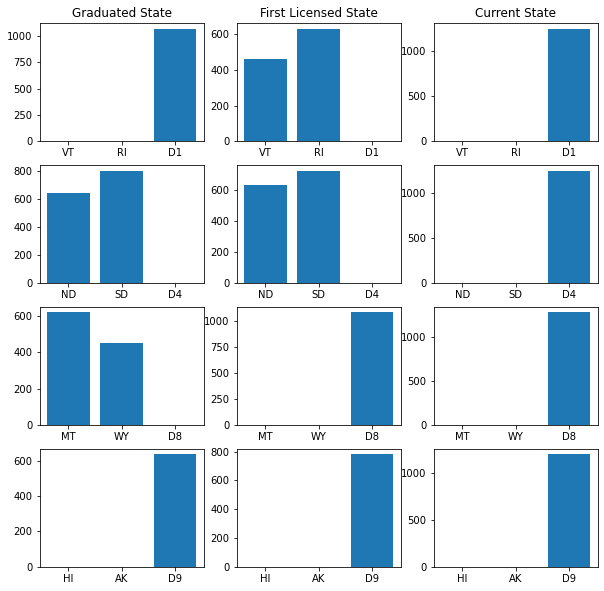

In [17]:
titles=['Graduated State', 'First Licensed State', 'Current State']
varnames=['ED_NDLOC_ST_PUF','ED_FRN_ST_PUF','PN_LOC_ST_PUF']
fig, ax = plt.subplots(4,3,figsize=(10,10))
for vi, vn in enumerate(varnames):    
    region_plots=[]
    for key in list(region.keys()):
        temp=[df_2018[df_2018[vn]==st].shape[0] for st in region[key]]
        temp.append(df_2018[df_2018[vn]==key].shape[0])
        region_plots.append(temp)
        
    
    for i in range(4):
        key = list(region.keys())[i]
        xlabel = copy.copy(region[key])
        xlabel.append(key)
        
        ax[i,vi].bar(xlabel,region_plots[i])
        
    ax[0,vi].set_title(titles[vi])

Since current state is only reported at the regional level for these states, it makes sense to combine each region's data into one group for all states in the region.
States in D1(RI, VT), D4(ND, SD), and D8(MT, WY) are geographically close, so combining these states isn't too far-fetched. D9(AK, HI) states are only reported at the regional level for all three metrics so we have no other choice.

In [18]:
for key in region.keys():
    for st in region[key]:
        for vn in varnames:
            df_2018.loc[df_2018[vn]==st,vn]=key

Now, AK and HI are obviously very different states, so any insights drawn from D9 might be useless. However, since we will be looking at the rates at which nurses enter and leave each state, and since they are both outside the contiguous United States, they will pose similar hurdles for people looking to transiton in/out of these states. Therefore, the insights drawn from D9 data might still prove useful.

Let's examine the relation between graduated state and first licensed state. I will be assuming that first licensed state will be the state where each nurse had their first job.

In [21]:
df_gfc = pd.DataFrame({'grad':df_2018['ED_NDLOC_ST_PUF'].value_counts(),'first':df_2018['ED_FRN_ST_PUF'].value_counts(),'current':df_2018['PN_LOC_ST_PUF'].value_counts()})
df_gfc.drop(index='.L',inplace=True)

graduated_state_axis = df_gfc['grad'].sort_values(ascending=False).index
first_state_axis = df_gfc['first'].sort_values(ascending=False).index
current_state_axis = df_gfc['current'].sort_values(ascending=False).index

"""heatmap - graduate vs first state"""
hm_gf_raw = np.zeros(shape=(df_gfc.shape[0],df_gfc.shape[0]),dtype=int) #y,x

for gsi,gs in enumerate(graduated_state_axis):
    s1 = df_2018.loc[lambda df:df['ED_NDLOC_ST_PUF']==gs,'ED_FRN_ST_PUF'].value_counts() # first state series filtered for graduated state    
    for fsi,fs in enumerate(graduated_state_axis):  #enumerate over gsa so x and y axis will have the same order
        try:
            hm_gf_raw[gsi][fsi] += s1[fs]
        except:
            pass
            
#normalize by the total graduate number
hm_gf = np.zeros(shape=(df_gfc.shape[0],df_gfc.shape[0]),dtype=int)
for gsi,gs in enumerate(graduated_state_axis): 
    total = sum(hm_gf_raw[gsi,:])
    if total>0:
        hm_gf[gsi,:]=hm_gf_raw[gsi,:]/total*100;   

gf_stay_i = np.flip(np.argsort([hm_gf[i,i] for i in range(df_gfc.shape[0])]))
print("Percentage of graduates staying after graduation")
print("------------------------------------------------")
for i in range(df_gfc.shape[0]):
    print('{}: {}%'.format(graduated_state_axis[gf_stay_i[i]],hm_gf[gf_stay_i[i],gf_stay_i[i]]))


Percentage of graduates staying after graduation
------------------------------------------------
CA: 95%
LA: 95%
UT: 93%
D9: 92%
NM: 92%
AR: 92%
MI: 91%
NV: 91%
OK: 91%
MS: 91%
NJ: 90%
GA: 90%
KS: 90%
SC: 90%
ME: 90%
CO: 89%
OH: 89%
TX: 89%
IL: 88%
TN: 88%
AL: 88%
CT: 88%
KY: 87%
NC: 87%
WI: 87%
WV: 86%
D8: 86%
ID: 86%
FL: 86%
OR: 86%
AZ: 86%
IN: 85%
MA: 85%
NE: 85%
WA: 85%
MO: 84%
D4: 84%
MN: 84%
MD: 83%
D1: 82%
VA: 82%
DE: 82%
IA: 81%
PA: 80%
NY: 76%
NH: 75%
DC: 57%


As expected, all states get majority of their own graduates to stay for their first jobs.

Weighing by the total graduates of each state gives us a origin centric metric: it measures the percentage of graduates from each state(origin) that will go to a particular state(destination). If we normalize by first licensed state, it will give a destination centric metric: for each state's nursing population, it will tell us where they graduated from.

If we are interested in boosting the nursing population in a certain state, we do not care about destination, but 

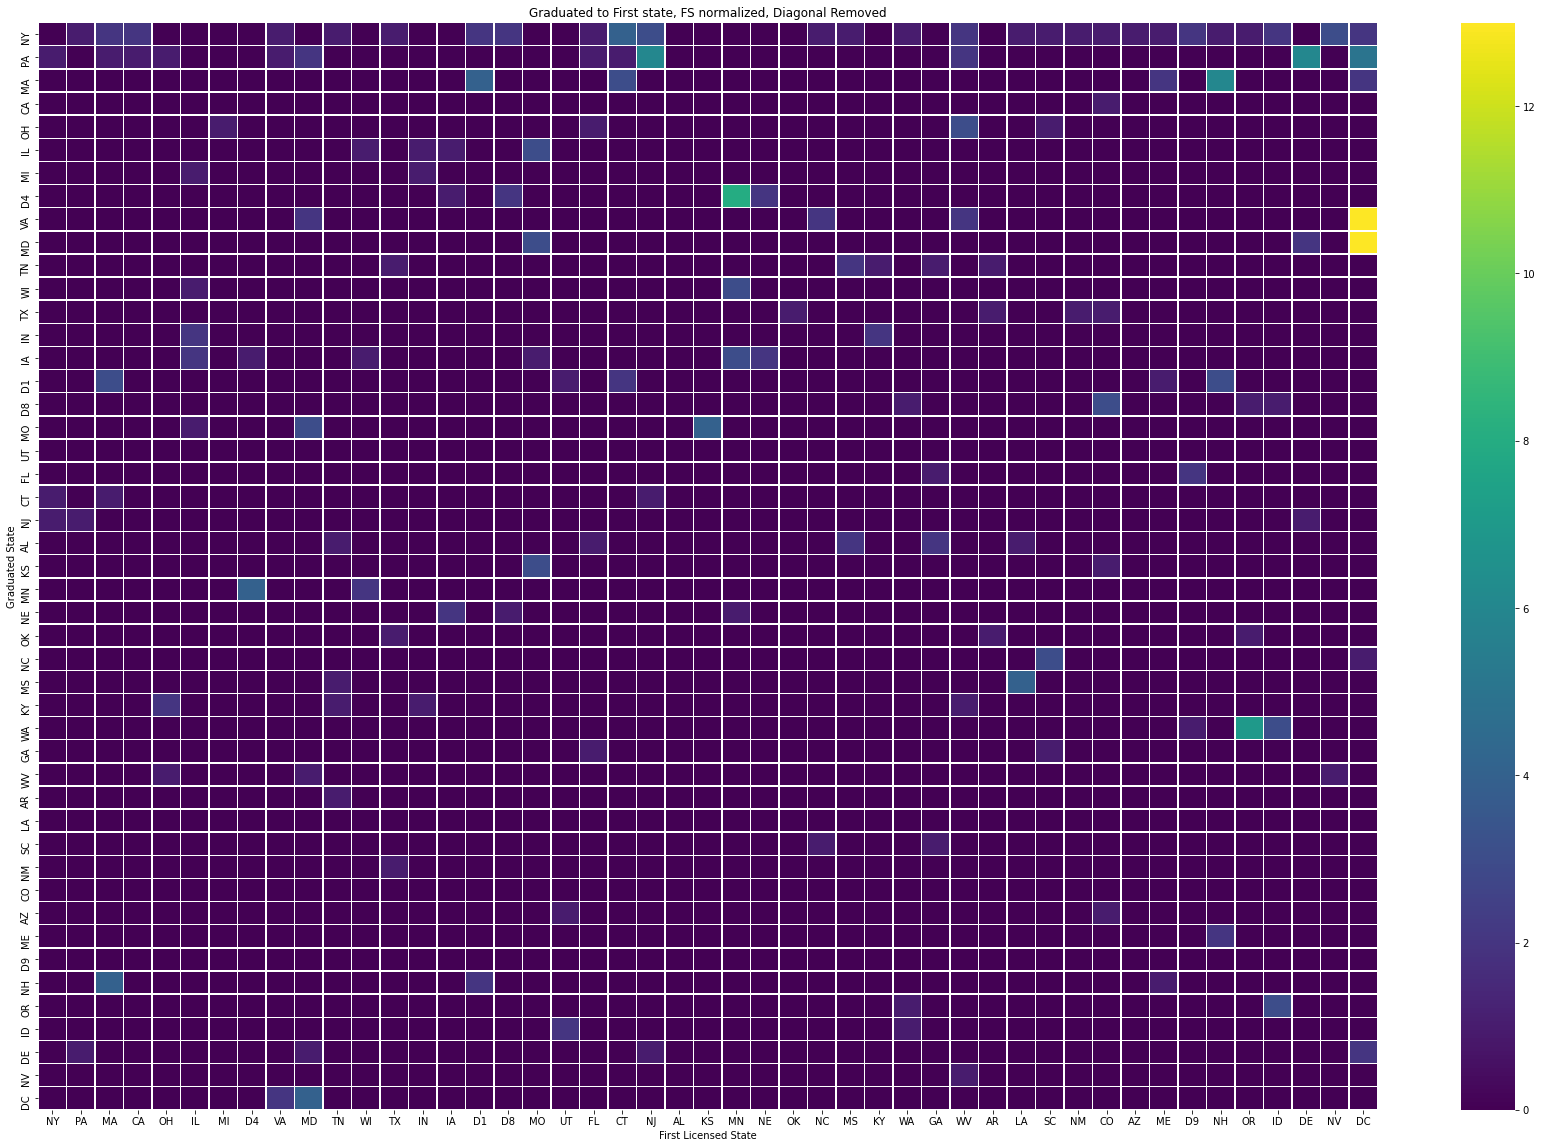

In [22]:
hm_fg = np.zeros(shape=(df_gfc.shape[0],df_gfc.shape[0]),dtype=int)
for gsi,gs in enumerate(graduated_state_axis): 
    total = sum(hm_gf_raw[:,gsi])
    if total>0:
        hm_fg[:,gsi]=hm_gf_raw[:,gsi]/total*100;

hm_fg_diag = copy.deepcopy(hm_fg)

for i in range(df_gfc.shape[0]):
    hm_fg_diag[i,i]=0
        
fig2, ax2 = plt.subplots(figsize=(30,20))
ax2 = sns.heatmap(hm_fg_diag, linewidth=0.5,cmap="viridis",xticklabels=graduated_state_axis,yticklabels=graduated_state_axis)
plt.title('Graduated to First state, FS normalized, Diagonal Removed')
plt.xlabel("First Licensed State")
plt.ylabel("Graduated State")
plt.show()  